In [31]:
# Imports
import praw
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import joblib
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS # From ChatGPT on how to get stopwords out after fitting the model
import re # from ChatGPT needed to remove numbers and symbols

In [2]:
np.random.seed(42)

# Table of Contents
1. [EDA](#eda)
2. [Model 1: Random Forest with RandomizedSearchCV](#model-1-random-forest-with-randomizedsearchcv)
3. [Model 2: Support Vector Machine with RandomizedSearchCV](#model-2-support-vector-machine-with-randomizedsearchcv)

## EDA

Load in from the .env file

In [3]:
# Commented out as I am not collecting any more data

# # Load the environment variables from the .env file
# load_dotenv('Reddit Info.env')

# # Access the env files
# secret_key = os.getenv('secret_key')
# reddit_username = os.getenv('reddit_username')
# reddit_password = os.getenv('reddit_password')
# personal_use_key = os.getenv('personal_use_key')

Access reddit 

In [4]:
# Commented out as I am not collecting any more data

# reddit = praw.Reddit(
#     client_id= personal_use_key,
#     client_secret = secret_key,
#     password= reddit_password,
#     user_agent = "Class Project 3 (by u/glittering-pack-9564)",
#     username = reddit_username,
# )

# # checking to make sure it worked
# # should be false
# print(reddit.read_only)

Choose two subreddits and get posts

In [5]:
# Commented out as I am not collecting any more data

# # Choosing subreddit and getting posts
# subreddit_wallstreetbets = reddit.subreddit('wallstreetbets')
# subreddit_stocks = reddit.subreddit('stocks')
# posts_wallstreetbets = subreddit_wallstreetbets.new(limit=100)
# posts_stocks = subreddit_stocks.new(limit=100)


# data_wallstreetbets = []
# for post in posts_wallstreetbets:
#     data_wallstreetbets.append([post.created_utc, post.title, post.selftext, post.subreddit])
    
# data_stocks = []
# for post in posts_stocks:
#     data_stocks.append([post.created_utc, post.title, post.selftext, post.subreddit])

# # Turn into a dataframe
# wallstreetbets = pd.DataFrame(data_wallstreetbets, columns = ['created_utc', 'title', 'self_text', 'subreddit'])
# stocks = pd.DataFrame(data_stocks, columns = ['created_utc', 'title', 'self_text', 'subreddit'])

# # Drop any duplicate posts
# wallstreetbets = wallstreetbets.drop_duplicates(subset=['created_utc', 'title'])
# stocks = stocks.drop_duplicates(subset=['created_utc', 'title'])


Append posts to a .csv file in order to save and get back a dataframe from the .csv file

In [6]:
# Commented out as I am not collecting any more data

# # saves data to csv and appends new data
# wallstreetbets.to_csv('./data/Wallstreetbets data.csv',
#                      mode = 'a', # appending to the .csv file
#                      index = False,
#                      header = False) # taking off the headers for easier appending

# stocks.to_csv('./data/stocks data.csv',
#                      mode = 'a',
#                      index = False,
#                      header = False)

# gets back all the data with the new posts
wallstreetbets = pd.read_csv('./data/Wallstreetbets data.csv',names=['created_utc', 'title', 'self_text', 'subreddit'])
stocks = pd.read_csv('./data/Stocks data.csv',names = ['created_utc', 'title', 'self_text', 'subreddit'])

In [7]:
wallstreetbets.shape

(1100, 4)

In [8]:
wallstreetbets.head()

,created_utc,title,self_text,subreddit
0,1.731948e+09,Bear Market due to bad NVIDIA Earning?,Reasoning:\n\n1. Due to the rising yields the ...,wallstreetbets
1,1.731948e+09,Doing the inverse from now on,How to make a lose-lose situation. Exhibit A\n...,wallstreetbets
2,1.731947e+09,Wen moon?,NaN,wallstreetbets
3,1.731947e+09,Me forgetting NVDA earnings is this week and q...,I think I’m done.,wallstreetbets
4,1.731946e+09,TIL Peloton is not up to 200% in a year and va...,Every now and then I check my little trading a...,wallstreetbets


In [9]:
stocks.head()

,created_utc,title,self_text,subreddit
0,1.731948e+09,EQIX and DLR - are they benefitting at all fro...,I had been wondering if datacenter REIT's such...,stocks
1,1.731947e+09,"What are some high risk, high reward stocks I ...","I'm still in high school, so I don't pay any e...",stocks
2,1.731947e+09,Creating Stop Loss on Webull?,I'm trying to create my first stop Loss on Web...,stocks
3,1.731945e+09,S&P 500 Rebalancing Trade,The S&P 500 index rebalancing occurs 4x/year w...,stocks
4,1.731945e+09,BioNTech Analysis and Questions,Let me first talk about the BioNTech's Q3 2024...,stocks


In [10]:
stocks.shape

(1100, 4)

In [11]:
wallstreetbets.isnull().sum()

created_utc      0
title            0
self_text      327
subreddit        0
dtype: int64

In [12]:
stocks.isnull().sum()

created_utc    0
title          0
self_text      0
subreddit      0
dtype: int64

Get rid of any null values for both DataFrames

In [13]:
# I know that the subreddit wallstreetbets sometimes will post images or videos with no text and only a title so I will replace NaNs with just a word
# I do not think the stocks subreddit is allowed to do that due to the rules of the subreddit but it cannot hurt.
wallstreetbets['self_text'] = wallstreetbets['self_text'].replace({np.nan:'Image'})
stocks['self_text'] = stocks['self_text'].replace({np.nan:'Image'})

Concatenate both dataframes

In [14]:
df_model_1 = pd.concat([wallstreetbets, stocks],
                      ignore_index = True) # the index does not matter 
df_model_1['subreddit'] = df_model_1['subreddit'].map({'wallstreetbets': 0,
                                         'stocks': 1})

In [15]:
df_model_1.head()

,created_utc,title,self_text,subreddit
0,1.731948e+09,Bear Market due to bad NVIDIA Earning?,Reasoning:\n\n1. Due to the rising yields the ...,0
1,1.731948e+09,Doing the inverse from now on,How to make a lose-lose situation. Exhibit A\n...,0
2,1.731947e+09,Wen moon?,Image,0
3,1.731947e+09,Me forgetting NVDA earnings is this week and q...,I think I’m done.,0
4,1.731946e+09,TIL Peloton is not up to 200% in a year and va...,Every now and then I check my little trading a...,0


## Model 1: Random Forest with RandomizedSearchCV

In [16]:
# commenting out because the model was saved 

X = df_model_1[['title','self_text']]
y = df_model_1['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y)

# pipe_1 = Pipeline([
#     ('cvec',CountVectorizer()),
#     ('rf', RandomForestClassifier())
# ])

# pipe_params_1 = {
#     'cvec__max_features': np.arange(400,551,10), # Max number of frequently occuring words to include
#     'cvec__min_df': np.arange(1,11),  # Lowest amount of times a word can appear to be included
#     'cvec__max_df': [0.8, 0.95], # exclude words that appear in 80% or more of the posts
#     'cvec__ngram_range': [(1,1), (1,2), (1,3)], # n-grams uni, bi, tri
#     'rf__n_estimators': np.arange(50,250),  # Number of trees in the forest
#     'rf__max_depth': np.arange(1,31),  # Maximum depth of the tree
#     'rf__min_samples_split': [2,3,4],  # Minimum number of samples to split a node
# }

# rs_1 = RandomizedSearchCV(
#     pipe_1, 
#     pipe_params_1,
#     n_iter = 50,
#     cv=5,
#     n_jobs = -1 # use all available cores
# )


# Best Parameters: {'rf__n_estimators': 113, 'rf__min_samples_split': 3, 'rf__max_depth': 30, 'cvec__ngram_range': (1, 3), 'cvec__min_df': 6, 'cvec__max_features': 410, 'cvec__max_df': 0.8}
# Best Cross-Validation Score: 0.9848484848484848
# Training Accuracy: 0.9981818181818182
# Test Accuracy: 0.9818181818181818

In [17]:
# %%time
# rs_1.fit(X_train['title'] + " " + X_train['self_text'], y_train)


# # save the model
# # Credit to chatgpt for showing me this
# joblib.dump(rs_1,'./Models/Random Forest Model 1.pkl')

# Reload model
# Changed name of model to rf_1 from rs_1
rf_1 = joblib.load('./Models/Random Forest Model 1.pkl')

In [18]:
print('Best Parameters:', rf_1.best_params_)
print('Best Cross-Validation Score:', rf_1.best_score_)
print('Training Accuracy:', rf_1.score(X_train['title'] + " " + X_train['self_text'],y_train))
print('Test Accuracy:', rf_1.score(X_test['title'] + " " + X_test['self_text'],y_test))

Best Parameters: {'rf__n_estimators': 113, 'rf__min_samples_split': 3, 'rf__max_depth': 30, 'cvec__ngram_range': (1, 3), 'cvec__min_df': 6, 'cvec__max_features': 410, 'cvec__max_df': 0.8}
Best Cross-Validation Score: 0.9848484848484848
Training Accuracy: 0.9981818181818182
Test Accuracy: 0.9818181818181818


### Make graphs to talk about the data

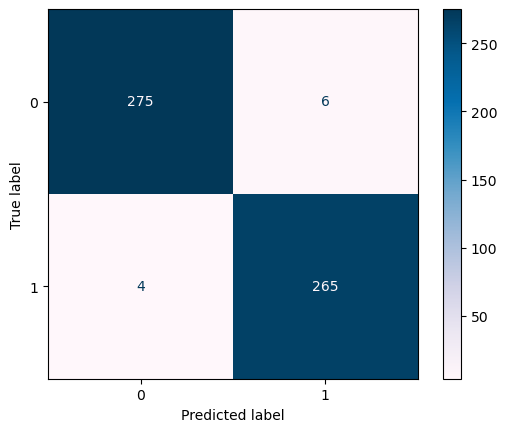

In [19]:
ConfusionMatrixDisplay.from_estimator(rf_1,X_test['title'] + " " + X_test['self_text'],y_test, cmap = 'PuBu');

In [43]:
y_pred = rf_1.predict(X_test['title'] + " " + X_test['self_text'])

# Classification report
report = classification_report(y_test,y_pred)
# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       281
           1       0.98      0.99      0.98       269

    accuracy                           0.98       550
   macro avg       0.98      0.98      0.98       550
weighted avg       0.98      0.98      0.98       550



The model was fit without removing stop words so remove them now so more interesting data can be found

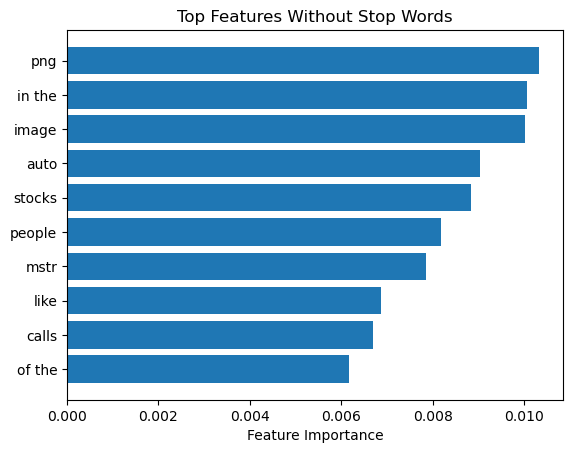

In [20]:
# Get the trained vectorizer from your pipeline
vectorizer = rf_1.best_estimator_.named_steps['cvec']

# Extract feature names from the CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the Random Forest classifier from the pipeline
model = rf_1.best_estimator_.named_steps['rf']

# Get feature importances from the Random Forest model
importances = model.feature_importances_

# Filter out stop words
non_stop_word_indices = [i for i, word in enumerate(feature_names) if word not in ENGLISH_STOP_WORDS]
filtered_features = feature_names[non_stop_word_indices]
filtered_importances = importances[non_stop_word_indices]


# Display top features without stop words
top_indices = np.argsort(filtered_importances)[-10:]
top_features = filtered_features[top_indices]
top_importances = filtered_importances[top_indices]


plt.barh(top_features, top_importances)
plt.xlabel("Feature Importance")
plt.title("Top Features Without Stop Words")
plt.show()

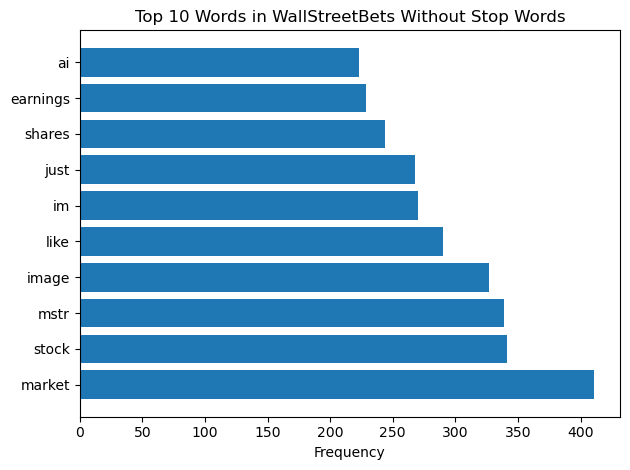

<Figure size 640x480 with 0 Axes>

In [40]:
# Concatenate all text for each subreddit
wallstreetbets_text = re.sub(r"[^a-zA-Z0-9\s]", "", # ChatGPT gave me this re.sub part
    " ".join(df_model_1[df_model_1['subreddit'] == 0]['title'] + " " +
             df_model_1[df_model_1['subreddit'] == 0]['self_text']).lower())

stocks_text = re.sub(r"[^a-zA-Z0-9\s]", "", 
    " ".join(df_model_1[df_model_1['subreddit'] == 1]['title'] + " " +
             df_model_1[df_model_1['subreddit'] == 1]['self_text']).lower())

# Count word frequencies
wallstreetbets_counts = pd.Series(wallstreetbets_text.split()).value_counts()
stocks_counts = pd.Series(stocks_text.split()).value_counts()

# Filter out stop words
wallstreetbets_filtered_counts = wallstreetbets_counts[~wallstreetbets_counts.index.isin(ENGLISH_STOP_WORDS)]
stocks_filtered_counts = stocks_counts[~stocks_counts.index.isin(ENGLISH_STOP_WORDS)]

# Get top 10 most frequent words for each subreddit
top_wallstreetbets_words = wallstreetbets_filtered_counts.head(10)
top_stocks_words = stocks_filtered_counts.head(10)

# Plot for WallStreetBets
plt.barh(top_wallstreetbets_words.index, top_wallstreetbets_words.values)
plt.title('Top 10 Words in WallStreetBets Without Stop Words')
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()

plt.savefig('./Images/Top 10 Words in Wallstreetbets (Stop Words Removed)')

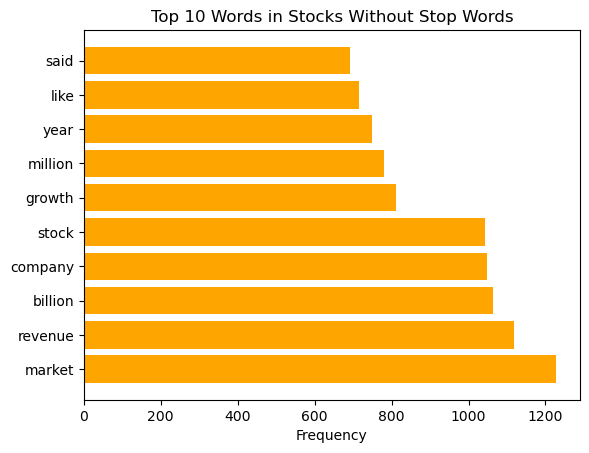

In [42]:
# Plot for Stocks
plt.barh(top_stocks_words.index, top_stocks_words.values, color='orange')
plt.title('Top 10 Words in Stocks Without Stop Words')
plt.xlabel('Frequency')
plt.savefig('./Images/Top 10 Words in Stocks (Stop Words Removed)')

## Model 2: Support Vector Machine with RandomizedSearchCV

In [19]:
# commenting out because the model was saved

# X = df_model_1[['title','self_text']]
# y = df_model_1['subreddit']
# X_train, X_test, y_train, y_test = train_test_split(X, y)

# pipe_2 = Pipeline([
#     ('cvec',CountVectorizer()),
#     ('svm', SVC(kernel = 'rbf'))
# ])

# pipe_params_2 = {
#     'cvec__max_features': [500,700,1000], # Max number of frequently occuring words to include
#     'cvec__min_df': [5,15,20,30],  # Lowest amount of times a word can appear to be included
#     'cvec__max_df': [0.8, 0.95], # exclude words that appear in 80% or more of the posts
#     'cvec__ngram_range': [(1,1), (1,2), (1,3)], # n-grams uni, bi, tr,
#     'svm__C': np.linspace(0.001,2,10),  # Regularization parameter
# }

# rs_2 = RandomizedSearchCV(
#     pipe_2, 
#     pipe_params_2,
#     n_iter = 500,
#     cv=5,
#     n_jobs = -1 # use all available cores
# )


# Best Parameters: {'svm__C': 2.0, 'cvec__ngram_range': (1, 1), 'cvec__min_df': 15, 'cvec__max_features': 1000, 'cvec__max_df': 0.95}
# Best Cross-Validation Score: 0.9745454545454544
# Training Accuracy: 0.990909090909091
# Test Accuracy: 0.9654545454545455

In [20]:
# %%time
# rs_2.fit(X_train['title'] + " " + X_train['self_text'], y_train)

# save the model
# joblib.dump(rs_2,'./Models/Support Vector Machine Model.pkl')

# Reload model
svm_1 = joblib.load('./Models/Support Vector Machine Model.pkl')

CPU times: total: 16.7 s
Wall time: 3min 38s


In [21]:
print('Best Parameters:', svm_1.best_params_)
print('Best Cross-Validation Score:', svm_1.best_score_)
print('Training Accuracy:', svm_1.score(X_train['title'] + " " + X_train['self_text'],y_train))
print('Test Accuracy:', svm_1.score(X_test['title'] + " " + X_test['self_text'],y_test))

Best Parameters: {'svm__C': 2.0, 'cvec__ngram_range': (1, 1), 'cvec__min_df': 15, 'cvec__max_features': 1000, 'cvec__max_df': 0.95}
Best Cross-Validation Score: 0.9745454545454544
Training Accuracy: 0.990909090909091
Test Accuracy: 0.9654545454545455
